# DeepSphere using SHREC17 dataset
### Benchmark with Cohen method S2CNN[[1]](http://arxiv.org/abs/1801.10130) and Esteves method[[2]](http://arxiv.org/abs/1711.06721)
Multi-class classification of 3D objects, using the interesting property of rotation equivariance.

The 3D objects are projected on a unit sphere.
Cohen and Esteves use equiangular sampling, while our method use a HEAlpix sampling

Several features are collected:
* projection ray length (from sphere border to intersection [0, 2])
* cos/sin with surface normal
* same features using the convex hull of the 3D object

## 0.1 Load libs

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import os
import shutil
import sys

os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # change to chosen GPU to use, nothing if work on CPU

import numpy as np
import time
import matplotlib.pyplot as plt
import healpy as hp

In [ ]:
from deepsphere import models, experiment_helper, plot, utils
from deepsphere.data import LabeledDatasetWithNoise, LabeledDataset
import hyperparameters

from SHREC17.load_shrec import fix_dataset, Shrec17Dataset, Shrec17DatasetCache, Shrec17DatasetTF

## 0.2 Define parameters

In [ ]:
Nside = 32
experiment_type = 'CNN' # 'FCN'
ename = '_'+experiment_type
datapath = '../data/shrec17/' # localisation of the .obj files

In [ ]:
noise_dataset = True    # use perturbed dataset (Cohen and Esteves do the same)
augmentation = 3        # number of element per file (1 = no augmentation of dataset)
nfeat = 6

## 1 Load dataset

In [ ]:
# if datasets are already downloaded but not preprocessed
fix = False
download = False
if fix:
    fix_dataset(datapath+'val_perturbed')
    fix_dataset(datapath+'test_perturbed')

download dataset if True, preprocess data and store it in npy files, and load it in a dataset object

In [7]:
# train_dataset = Shrec17Dataset(datapath, 'train', perturbed=noise_dataset, download=download, nside=Nside, augmentation=augmentation, nfile=None, load=False)


Better to keep validation and testing set in RAM, but not always possible

In [ ]:
val_dataset = Shrec17DatasetCache(datapath, 'val', perturbed=noise_dataset, download=download, nside=Nside, nfeat=nfeat, augmentation=1, nfile=None)

In [ ]:
val_nonrot_dataset = Shrec17DatasetCache(datapath, 'val', perturbed=noise_dataset, download=download, nside=Nside, nfeat=nfeat, experiment='deepsphere_norot', augmentation=1, nfile=None)

Try do make a tensorflow dataset object

In [ ]:
train_TFDataset = Shrec17DatasetTF(datapath, 'train', perturbed=noise_dataset, download=download, nside=Nside, nfeat=nfeat, augmentation=augmentation, nfile=None, experiment='deepsphere')

In [10]:
#dataset = train_TFDataset.get_tf_dataset(32)

In [11]:
# import time
# import tensorflow as tf

# #dataset = tf_dataset_file(datapath, dataset, file_pattern, 32, Nside, augmentation)
# t_start = time.time()
# data_next = dataset.make_one_shot_iterator().get_next()
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# steps = train_TFDataset.N // 32 + 1
# with tf.Session(config=config) as sess:
#     sess.run(tf.global_variables_initializer())
#     try:
#         for i in range(steps):
#             out = sess.run(data_next)
#     except tf.errors.OutOfRangeError:
#         print("Done") # Never reach this as will iterate on infinite sets
# t_end = time.time()
# print(str(t_end-t_start)+" s")

# # t_start = time.time()
# # data_iter = train_dataset.iter(32)
# # steps = int(train_dataset.N / 32)
# # for i in range(steps):
# #     next(data_iter)
# #     #feed_dict = {self.ph_data: batch_data, self.ph_labels: batch_labels, self.ph_training: True}
# # t_end = time.time()
# # print(str(t_end-t_start)+" s")

## 1.1 Preprocess the dataset

Shuffle the training dataset and print the classes distribution

In [ ]:
nclass = train_TFDataset.nclass
num_elem = train_TFDataset.N
#ids_train = train_dataset.ids
print('number of class:',nclass,'\nnumber of elements:',num_elem)#,'\nfirst id:',ids_train[0])

In [13]:
# x_val, labels_val, ids_val = val_dataset.return_data(train=False)

## 2 Classification using DeepSphere

Use of the Dataset object used for other DeepSphere experiments

In [15]:
# #training = LabeledDatasetWithNoise(x_train, labels_train, end_level=sigma_noise)
# #training = LabeledDataset(x_train, labels_train)
# validation = LabeledDataset(x_val, labels_val)

In [34]:
EXP_NAME = 'shrec17_Graph_Cohen_4K_{}feat_{}aug_{}sides{}'.format(nfeat, augmentation, Nside, ename)
#EXP_NAME = 'shrec17_Cohen_simple_SGD_max_nsides_300epoch_{}sides{}'.format(Nside, ename)
#EXP_NAME = 'shrec17_newBestGraph_best_4K_triplet_all_{}aug_{}sides{}'.format(augmentation, Nside, ename)
#EXP_NAME = 'essai_0loss'

Load model with hyperparameters chosen.
For each experiment, a new EXP_NAME is chosen, and new hyperparameters are store.
All informations are present 'DeepSphere/Shrec17/experiments.md'
The fastest way to reproduce an experiment is to revert to the commit of the experiment to load the correct files and notebook

Adding a layer in the fully connected can be beneficial

In [35]:
params = hyperparameters.get_params_shrec17(num_elem, EXP_NAME, Nside, nclass, nfeat_in=nfeat, architecture=experiment_type)
params["tf_dataset"] = train_TFDataset.get_tf_dataset(params["batch_size"])
#params["std"] = [0.002, 0.009, 0.025, 0.09, 0.15, 0.5]
#params["full"] = [True]*6
#params["extra_loss"]=True
model = models.deepsphere(**params)

#sides: [32, 8, 4, 4]
#pixels: [12288, 768, 192, 192]
#samples per batch: 32
=> #pixels per batch (input): 393,216
=> #pixels for training (input): 115,620,249,600
Learning rate will start at 5.0e-01 and finish at 5.0e-01.
NN architecture
  input: M_0 = 12288
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 12288 * 100 / 16 = 76800
    weights: F_0 * F_1 * K_1 = 6 * 100 * 5 = 3000
    biases: F_1 = 100
    batch normalization
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 768 * 100 / 4 = 19200
    weights: F_1 * F_2 * K_2 = 100 * 100 * 5 = 50000
    biases: F_2 = 100
    batch normalization
  Statistical layer: mean
    representation: 1 * 100 = 100
  layer 3: logits (softmax)
    representation: M_3 = 55
    weights: M_2 * M_3 = 100 * 55 = 5500


In [33]:
#EXP_NAME = "shrec17_best_4K_cache_1aug_128sides_CNN"
shutil.rmtree('summaries/{}/'.format(EXP_NAME), ignore_errors=True)
shutil.rmtree('checkpoints/{}/'.format(EXP_NAME), ignore_errors=True)

Find a correct learning rate

In [ ]:
backup = params.copy()

params, learning_rate = utils.test_learning_rates(params, train_TFDataset.N, 1e-6, 1e-1, num_epochs=20)

shutil.rmtree('summaries/{}/'.format(params['dir_name']), ignore_errors=True)
shutil.rmtree('checkpoints/{}/'.format(params['dir_name']), ignore_errors=True)

model = models.deepsphere(**params)
_, loss_validation, _, _ = model.fit(train_TFDataset, val_dataset, use_tf_dataset=True, cache=True)

params.update(backup)

plt.semilogx(learning_rate, loss_validation, '.-')

NN architecture
  input: M_0 = 196608
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 196608 * 16 / 4 = 786432
    weights: F_0 * F_1 * K_1 = 6 * 16 * 5 = 480
    biases: F_1 = 16
    batch normalization
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 49152 * 32 / 4 = 393216
    weights: F_1 * F_2 * K_2 = 16 * 32 * 5 = 2560
    biases: F_2 = 32
    batch normalization
  layer 3: cgconv3
    representation: M_2 * F_3 / p_3 = 12288 * 64 / 4 = 196608
    weights: F_2 * F_3 * K_3 = 32 * 64 * 5 = 10240
    biases: F_3 = 64
    batch normalization
  layer 4: cgconv4
    representation: M_3 * F_4 / p_4 = 3072 * 128 / 4 = 98304
    weights: F_3 * F_4 * K_4 = 64 * 128 * 5 = 40960
    biases: F_4 = 128
    batch normalization
  layer 5: cgconv5
    representation: M_4 * F_5 / p_5 = 768 * 256 / 4 = 49152
    weights: F_4 * F_5 * K_5 = 128 * 256 * 5 = 163840
    biases: F_5 = 256
    batch normalization
  Statistical layer: mean
    representation: 1 * 256 = 256
  layer 6: logits

/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


  validation accuracy: 0.76 (39 / 5133), f1 (weighted): 0.80, loss: 4.29e+00
  CPU time: 1477s, wall time: 797s, perf_time_load: 1.16s, perf_time: 1.16s
step 980 / 19602 (epoch 1.00 / 20):
  learning_rate = 3.16e-06, training loss = 4.13e+00
  validation accuracy: 3.78 (194 / 5133), f1 (weighted): 2.88, loss: 4.19e+00
  CPU time: 2964s, wall time: 1587s, perf_time_load: 1.13s, perf_time: 1.13s
step 1470 / 19602 (epoch 1.50 / 20):
  learning_rate = 5.62e-06, training loss = 4.08e+00
  validation accuracy: 10.29 (528 / 5133), f1 (weighted): 4.54, loss: 4.00e+00
  CPU time: 4446s, wall time: 2374s, perf_time_load: 1.16s, perf_time: 1.16s
step 1960 / 19602 (epoch 2.00 / 20):
  learning_rate = 9.99e-06, training loss = 3.78e+00
  validation accuracy: 26.57 (1364 / 5133), f1 (weighted): 15.49, loss: 3.70e+00
  CPU time: 5924s, wall time: 3166s, perf_time_load: 1.15s, perf_time: 1.15s
step 2450 / 19602 (epoch 2.50 / 20):
  learning_rate = 1.78e-05, training loss = 3.08e+00
  validation accura

In [ ]:
shutil.rmtree('summaries/lr_finder/', ignore_errors=True)
shutil.rmtree('checkpoints/lr_finder/', ignore_errors=True)

0.9 seems to be a good learning rate for SGD with current parameters

## 2.2 Train Network

In [31]:
print("the number of parameters in the model is: {:,}".format(model.get_nbr_var()))

conv1/weights:0
conv1/bias:0
conv2/weights:0
conv2/bias:0
logits/weights:0
the number of parameters in the model is: 90,500


In [32]:
accuracy_validation, loss_validation, loss_training, t_step, t_batch = model.fit(train_TFDataset, val_dataset, use_tf_dataset=True, cache=True)

step 1470 / 294037 (epoch 0.50 / 100):
  learning_rate = 5.00e-01, training accuracy = 78.12, training loss = 1.17e+00


/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


  validation accuracy: 71.85 (3688 / 5133), f1 (weighted): 69.82, loss: 1.07e+00
  CPU time: 379s, wall time: 210s, perf_time_load: 0.13s, perf_time: 0.00s


KeyboardInterrupt: 

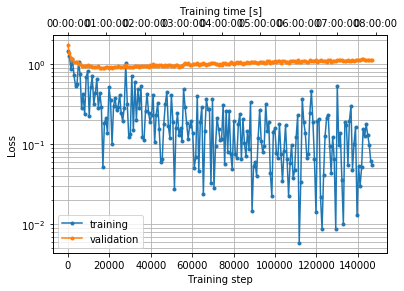

In [109]:
plot.plot_loss(loss_training, loss_validation, t_step, params['eval_frequency'])

Remarks

In [110]:
model.evaluate(x_train, labels_train)

NameError: name 'x_train' is not defined

In [ ]:
#predictions, loss = model.predict(x_val, labels_val)

In [17]:
# model.evaluate(x_val, labels_val)
model.evaluate(val_dataset, None, cache=True)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Graph_Cohen_4K_6feat_3aug_32sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Graph_Cohen_4K_6feat_3aug_32sides_CNN/model-166110


('accuracy: 81.41 (4179 / 5133), f1 (weighted): 80.68, loss: 7.91e-01\nCPU time: 22s, wall time: 21s',
 81.41437755698422,
 80.67557539015563,
 0.791224667511789)

In [18]:
model.evaluate(val_nonrot_dataset, None, cache=True)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Graph_Cohen_4K_6feat_3aug_32sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Graph_Cohen_4K_6feat_3aug_32sides_CNN/model-166110


('accuracy: 80.91 (4153 / 5133), f1 (weighted): 80.18, loss: 7.90e-01\nCPU time: 17s, wall time: 16s',
 80.90785115916617,
 80.18294874128193,
 0.7897724651951272)

In [129]:
# probabilities = model.probs(x_val, nclass)
probabilities, _ = model.probs(val_dataset, nclass, cache=True)
# if augmentation>1:
#     probabilities = probabilities.reshape((-1,augmentation,nclass))
#     probabilities = probabilities.mean(axis=1)
    #ids_val = ids_val[::repeat]
predictions = np.argmax(probabilities, axis=1)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_newBestGraphFull_best_4K_triplet_norot_3aug_32sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_newBestGraphFull_best_4K_triplet_norot_3aug_32sides_CNN/model-147018


In [135]:
# probabilities = model.probs(x_val, nclass)
probabilities, _ = model.probs(val_nonrot_dataset, nclass, cache=True)
# if augmentation>1:
#     probabilities = probabilities.reshape((-1,augmentation,nclass))
#     probabilities = probabilities.mean(axis=1)
    #ids_val = ids_val[::repeat]
predictions = np.argmax(probabilities, axis=1)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_newBestGraphFull_best_4K_triplet_norot_3aug_32sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_newBestGraphFull_best_4K_triplet_norot_3aug_32sides_CNN/model-147018


In [127]:
ids_val = val_dataset.get_ids()

In [20]:
#predictions = predictions.astype(np.int)

In [119]:
from SHREC17.load_shrec import shrec_output

In [136]:
shrec_output(model.get_descriptor(val_dataset), ids_val, probabilities, datapath, 'results/val_perturbed')

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_newBestGraphFull_best_4K_triplet_norot_3aug_32sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_newBestGraphFull_best_4K_triplet_norot_3aug_32sides_CNN/model-147018


In [137]:
# for every file, find every object with the same class, sorted by most relevance
os.makedirs(os.path.join(datapath,'results_aug/val_perturbed'), exist_ok=True)
for i,_id in enumerate(ids_val):
    idfile = os.path.join(datapath,'results_aug/val_perturbed',_id)
    # predictions batchxclass
    # pred_class batch == predictions
    retrieved = [(probabilities[j, predictions[j]], ids_val[j]) for j in range(len(ids_val)) if predictions[j] == predictions[i]]
    retrieved = sorted(retrieved, reverse=True)
    retrieved = [i for _, i in retrieved]
    with open(idfile, "w") as f:
        f.write("\n".join(retrieved))

NaN appears if remove i==j case

## test network

In [36]:
test_dataset = Shrec17Dataset(datapath, 'test', perturbed=noise_dataset, download=download, nside=Nside, augmentation=1, nfile=None)

10265it [00:10, 954.60it/s]


In [20]:
test_nonrot_dataset = Shrec17DatasetCache(datapath, 'test', perturbed=noise_dataset, download=download, 
                                          nside=Nside, experiment='deepsphere_norot', augmentation=augmentation, nfile=None)

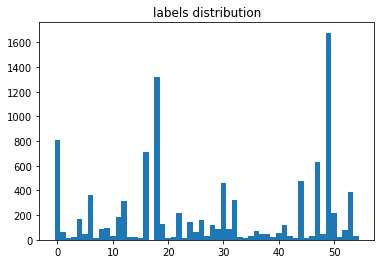

In [37]:
x_test, labels_test, ids_test = test_dataset.return_data(train=False)

In [22]:
model.evaluate(x_test, labels_test)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Graph_Cohen_4K_6feat_3aug_32sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Graph_Cohen_4K_6feat_3aug_32sides_CNN/model-166110


('accuracy: 76.83 (23660 / 30795), f1 (weighted): 76.66, loss: 9.70e-01\nCPU time: 64s, wall time: 57s',
 76.83065432700114,
 76.6615539577081,
 0.9696400432090013)

In [23]:
model.evaluate(test_nonrot_dataset, None, cache=True)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Graph_Cohen_4K_6feat_3aug_32sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Graph_Cohen_4K_6feat_3aug_32sides_CNN/model-166110


('accuracy: 76.78 (23645 / 30795), f1 (weighted): 76.53, loss: 9.65e-01\nCPU time: 132s, wall time: 140s',
 76.7819451209612,
 76.53133646828093,
 0.9650041672563684)

In [ ]:
#predictions = model.predict(x_test)

In [39]:
probabilities = model.probs(x_test, nclass)
# if augmentation>1:
#     probabilities = probabilities.reshape((-1,augmentation,nclass))
#     probabilities = probabilities.mean(axis=1)
#probabilities = np.log(probabilities)
predictions = np.argmax(probabilities, axis=1)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Graph_Cohen_4K_6feat_3aug_32sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Graph_Cohen_4K_6feat_3aug_32sides_CNN/model-166110


In [138]:
probabilities, _ = model.probs(test_nonrot_dataset, nclass, cache=True)
# if augmentation>1:
#     probabilities = probabilities.reshape((-1,augmentation,nclass))
#     probabilities = probabilities.mean(axis=1)
#probabilities = np.log(probabilities)
predictions = np.argmax(probabilities, axis=1)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_newBestGraphFull_best_4K_triplet_norot_3aug_32sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_newBestGraphFull_best_4K_triplet_norot_3aug_32sides_CNN/model-147018


In [ ]:
#predictions = predictions.astype(np.int)

write to file

In [41]:
# for every file, find every object with the same class, sorted by most relevance
os.makedirs(os.path.join(datapath,'results_aug/test_perturbed'), exist_ok=True)
for i, _id in enumerate(ids_test):
    idfile = os.path.join(datapath,'results_aug/test_perturbed',_id)
    # predictions batchxclass
    # pred_class batch == predictions
    retrieved = [(probabilities[j, predictions[j]], ids_test[j]) for j in range(len(ids_test)) if predictions[j] == predictions[i]]
    retrieved = sorted(retrieved, reverse=True)
    retrieved = [i for _, i in retrieved]
    with open(idfile, "w") as f:
        f.write("\n".join(retrieved))

In [140]:
shrec_output(model.get_descriptor(LabeledDataset(x_test, labels_test)), ids_test, probabilities, datapath, 'results/test_perturbed')

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_newBestGraphFull_best_4K_triplet_norot_3aug_32sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_newBestGraphFull_best_4K_triplet_norot_3aug_32sides_CNN/model-147018


Why not working?

In [141]:
def _print_histogram(nclass, labels_train, labels_min=None):
    if labels_train is None:
        return
    import matplotlib.pyplot as plt
    from collections import Counter
    hist_train=Counter(labels_train)
    if labels_min is not None:
        hist_min = Counter(labels_min)
        hist_temp = hist_train - hist_min
        hist_min = hist_min - hist_train
        hist_train = hist_temp + hist_min
#         for i in range(self.nclass):
#             hist_train.append(np.sum(labels_train == i))
    labels, values = zip(*hist_train.items())
    indexes = np.asarray(labels)
#     miss = set(indexes) - set(labels)
#     if len(miss) is not 0:
#         hist_train.update({elem:0 for elem in miss})
#     labels, values = zip(*hist_train.items())
    width = 1
    plt.bar(labels, values, width)
    plt.title("labels distribution")
    plt.ylim(0,1700)
    #plt.xticks(indexes + width * 0.5, labels)
    plt.show()

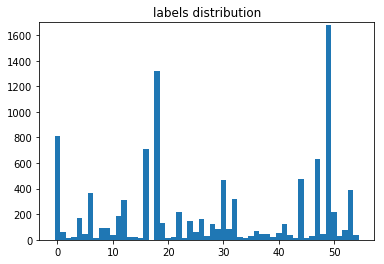

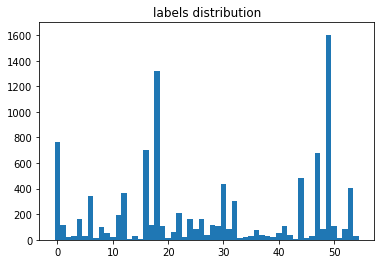

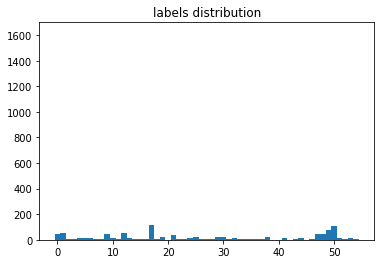

In [142]:
_print_histogram(55, labels_test)
_print_histogram(55, predictions)
_print_histogram(55, labels_test, predictions)

In [144]:
from sklearn.metrics import confusion_matrix

In [162]:
conf_mat = confusion_matrix(labels_test, predictions, range(55))

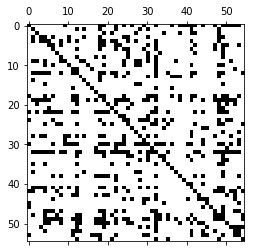

In [164]:
plt.spy(conf_mat, cmap = plt.cm.gist_heat_r)

In [187]:
lab1 = np.argsort((conf_mat-np.diag(np.diag(conf_mat))).sum(axis=1))[::-1][:7]

In [188]:
lab2 = np.argsort((conf_mat-np.diag(np.diag(conf_mat))).sum(axis=0))[::-1][:7]

In [178]:
dict_labels = {0: 'airplane',
               1: 'trashcan',
               2: 'bag',
               3: 'basket',
               4: 'bathtub',
               5: 'bed',
               6: 'bench',
               7: 'birdhouse',
               8: 'bookshelf',
               9: 'bottle',
               10: 'bowl',
               11: 'bus',
               12: 'cabinet',
               13: 'camera',
               14: 'can',
               15: 'cap',
               16: 'car',
               17: 'cellphone',
               18: 'chair',
               19: 'clock',
               20: 'keyboard',
               21: 'dishwasher',
               22: 'display',
               23: 'earphone',
               24: 'faucet',
               25: 'file cabinet',
               26: 'guitar',
               27: 'helmet',
               28: 'jar',
               29: 'knife',
               30: 'lamp',
               31: 'laptop',
               32: 'speaker',
               33: 'mailbox',
               34: 'microphone',
               35: 'microwave',
               36: 'motorcycle',
               37: 'mug',
               38: 'piano',
               39: 'pillow',
               40: 'pistol',
               41: 'flowerpot',
               42: 'printer',
               43: 'remote control',
               44: 'rifle',
               45: 'rocket',
               46: 'skateboard',
               47: 'sofa',
               48: 'stove',
               49: 'table',
               50: 'telephone',
               51: 'tower',
               52: 'train',
               53: 'vessel',
               54: 'washer'}

In [189]:
[dict_labels[lab] for lab in lab1]

['table', 'cabinet', 'telephone', 'speaker', 'lamp', 'bench', 'chair']

In [190]:
[dict_labels[lab] for lab in lab2]

['cabinet', 'table', 'speaker', 'cellphone', 'sofa', 'chair', 'lamp']